## 0. Contents

* ** Bayesian Nets **
* ** Structure Learning **
    * Constraint-Based
    * Scoring-Based
* ** Parameter Learning **
    * Frequentist Param-Learning (MLE)
    * Bayesian Param-Learning (MAP)
* ** Inference **
    * Exact Inference
        * Variable Elimination
        * Message Passing
    * Approx. Inference <== UNDER DEVELOPMENT
        * Optimization-Based
        * Particle-Based (Sampling)

## I. Bayes Nets

In [46]:
import json
from libpgm.graphskeleton import GraphSkeleton
from libpgm.nodedata import NodeData
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.tablecpdfactorization import TableCPDFactorization

In [38]:
from IPython.display import Image, display

### A. Simple Query

** a. BN Graph **

Student Network


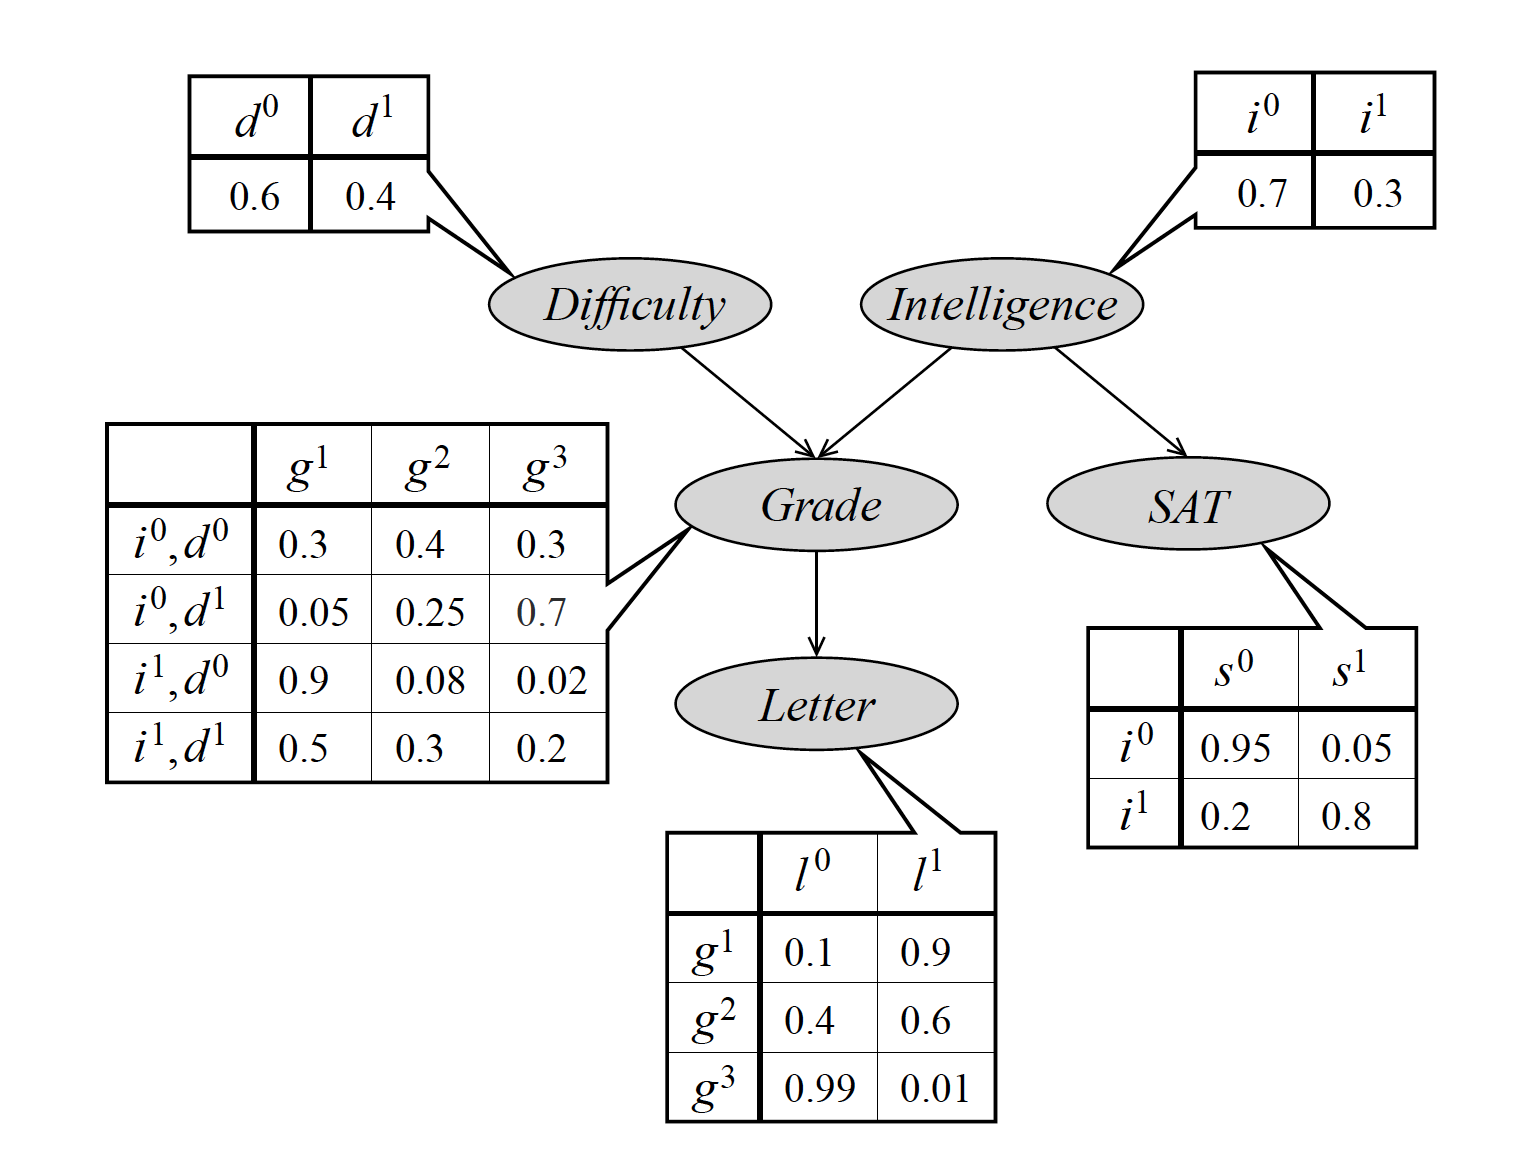

In [39]:
print "Student Network"
display(Image(filename='/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/FIGS/student_bn.png',
              width='50%'))

** b. Load Data **

In [40]:
dr1 = "/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/9004OS_Code/9004OS_02_Code/"

In [41]:
V = ['Difficulty','Intelligence','Grade','Letter','SAT']
E = [['Difficulty','Grade'],
     ['Intelligence','Grade'],
     ['Grade','Letter'],
     ['Intelligence','SAT']]
Vdata = {
    'Difficulty': {
        'parents': None,
        'children': ['Grade'],
        'ord': 1,
        'numoutcomes': 2,
        'cprob': [.6,.4],
        'vals': ["0","1"]
    },
    'Intelligence': {
        'parents': None,
        'children': ['Grade','SAT'], 
        'ord': 2,
        'numoutcomes': 2,
        'cprob': [.7,.3],
        'vals': ["0","1"]
    },
    'Grade': {
        'parents': ['Intelligence','Difficulty'],
        'children': ['Letter'],
        'ord': 3,
        'numoutcomes': 3,
        'cprob': {"['0', '0']": [.3,.4,.3], # the space between two 'x's in key is obligatory.
                  "['0', '1']": [.05,.25,.7],
                  "['1', '0']": [.9,.08,.02],
                  "['1', '1']": [.5,.3,.2]},
        'vals': ["1","2","3"]
    },
    'Letter': {
        'parents': ['Grade'],
        'children': None,
        'ord': 5,
        'numoutcomes': 2,
        'cprob': {"['1']": [.1,.9],
                  "['2']": [.4,.6],
                  "['3']": [.99,.01]},
        'vals': ["0","1"]
    },
    'SAT': {
        'parents': ['Intelligence'],
        'children': None,
        'ord': 4,
        'numoutcomes': 2,
        'cprob': {"['0']": [.95,.05],
                  "['1']": [.2,.8]},
        'vals': ["0","1"]
    } 
}

In [64]:
def get_table_cpd(dr,filename):
    nd = NodeData()
    skel = GraphSkeleton()
    json_path = dr+filename
    nd.load(json_path)
    skel.load(json_path)
    skel.toporder() 
    bn = DiscreteBayesianNetwork(skel,nd)
    table_cpd = TableCPDFactorization(bn)
    return table_cpd

In [65]:
student = {'Vdata': Vdata, 'V': V, 'E': E}

In [66]:
def encode_data(path, filename, data_dict):
    with open(path+filename,'w') as f:
        json.dump(data_dict,f)

In [67]:
encode_data(dr1, 'student.txt', student)

** c. Query **

In [68]:
tcpd = get_table_cpd(dr1, 'student.txt')

In [70]:
tcpd.condprobve?

In [69]:
tcpd.specificquery(query=dict(Intelligence='1'),evidence=dict(Grade='3')) # P(i=1|g=3)

0.07894736842105264

### B. Naive Bayes

In [178]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics, cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer

In [181]:
%%time
cats = ['alt.atheism', 'sci.med']
newsgroups = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'), categories=cats)

CPU times: user 3.08 s, sys: 138 ms, total: 3.22 s
Wall time: 3.22 s


In [188]:
print type(newsgroups)
print type(newsgroups.data), len(newsgroups.data) # data is a list of sentences in strings.
print type(newsgroups.target), len(newsgroups.target) # target is an array of 0/1s, labels of sentences' classes.

<class 'sklearn.datasets.base.Bunch'>
<type 'list'> 1789
<type 'numpy.ndarray'> 1789


In [191]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups.data)

In [194]:
vectors # unique word count = 66940; 1789 featurized entries, each corresponds to 1 sentence.

<1789x24202 sparse matrix of type '<type 'numpy.float64'>'
	with 183869 stored elements in Compressed Sparse Row format>

In [197]:
split_data = map(lambda s:s.split(' '), newsgroups.data)
words = [word for sent in split_data for word in sent]

In [201]:
clf = MultinomialNB(alpha=.01)
print "CrossValidation Score: ", np.mean(cross_validation.cross_val_score(clf, vectors, 
                                                                          newsgroups.target, scoring='f1'))

CrossValidation Score:  0.954420443456


## II. Structure Learning

### A. Constraint-Based Structure Learning 

In [152]:
from libpgm.nodedata import NodeData
from libpgm.graphskeleton import GraphSkeleton
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.pgmlearner import PGMLearner

In [204]:
dr1 = "/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/9004OS_Code/9004OS_02_Code/"
filename = "student.txt"

In [206]:
nd = NodeData()
skel = GraphSkeleton()
nd.load(dr1+filename)
skel.load(dr1+filename)
skel.toporder()
bn = DiscreteBayesianNetwork(skel, nd)

In [207]:
bn.randomsample(2) # randomly sample two assignments, i.e. Val(X)

[{u'Difficulty': u'0',
  u'Grade': u'2',
  u'Intelligence': u'0',
  u'Letter': u'1',
  u'SAT': u'0'},
 {u'Difficulty': u'0',
  u'Grade': u'1',
  u'Intelligence': u'1',
  u'Letter': u'1',
  u'SAT': u'1'}]

** a. $\chi^2$ Test **

* p-value: The probability that the independence is due to chance. Therefore if p-value > threshold, the null hypothesis --- two variables are independent --- cannot be due to chance.

In [242]:
def indep_test(X, Y, W, data, threshold=.05): # X,Y: pair of nodes in question; W: evidence; data: samples.
    learner = PGMLearner()
    c,p,w = learner.discrete_condind(data, X, Y, W)
    print "Result: chisq = %.2f | p = %.6f" % (c,p); "| witness = ", w
    print "Dependent" if p<threshold else "Independent"

In [243]:
# Causal: Difficulty -> Grade -> Letter (same with Evidential)
indep_test('Difficulty','Letter',[],bn.randomsample(1000)); print
indep_test('Difficulty','Letter',['Grade'],bn.randomsample(1000))

Result: chisq = 1084530819.47 | p = 0.000000
Dependent

Result: chisq = 2.92 | p = 0.991780
Independent


In [244]:
# Common Cause: Grade <- Intelligence -> SAT
indep_test('Grade','SAT',[],bn.randomsample(1000)); print
indep_test('Grade','SAT',['Intelligence'],bn.randomsample(1000))

Result: chisq = 1153959547.58 | p = 0.000000
Dependent

Result: chisq = 6.03 | p = 0.871267
Independent


In [251]:
# Common Effect: Difficulty -> Grade <- Intelligence
indep_test('Difficulty','Intelligence',[],bn.randomsample(1000)); print
indep_test('Difficulty','Intelligence',['Grade'],bn.randomsample(1000))

Result: chisq = 998007188.24 | p = 0.000000
Dependent

Result: chisq = 93.30 | p = 0.000000
Dependent


** b. I-equivalent Class Finding + Immoralization **

In [252]:
learner = PGMLearner()
result = learner.discrete_constraint_estimatestruct(bn.randomsample(1000))

In [253]:
print result.E

[[u'Intelligence', u'SAT'], [u'Difficulty', u'Grade'], [u'Intelligence', u'Grade'], [u'Grade', u'Letter']]


### B. Scoring-Based Structure Learning

** a. Scoring Samples from Data **

In [277]:
import json
import pandas as pd
from libpgm.nodedata import NodeData
from libpgm.graphskeleton import GraphSkeleton
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.pgmlearner import PGMLearner

In [254]:
dr1 = "/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/9004OS_Code/9004OS_02_Code/"
encode_data(dr1, 'student.txt', student) # data constructed in section I.

In [255]:
nd = NodeData()
skel = GraphSkeleton()
nd.load(dr1+'student.txt')
skel.load(dr1+'student.txt')
skel.toporder()
bn = DiscreteBayesianNetwork(skel, nd)

In [269]:
def sample_from_net(bn, n):
    samples = bn.randomsample(n) # list of {vertice: val} dicts.
    k = samples[0].keys() # get vertice names from one of the samples.
    col_dict = dict(zip(k,[[] for i in range(len(k))])) # produce {vertice: [], ..} dict.
    [col_dict[i].append(row[i]) for row in samples for i in k] # produce {vertice: list of vals, ..} dict.
    return col_dict

In [276]:
sample_from_net(bn,10)

{u'Difficulty': [u'1', u'1', u'0', u'0', u'1', u'1', u'0', u'0', u'0', u'1'],
 u'Grade': [u'3', u'3', u'1', u'2', u'2', u'2', u'3', u'2', u'2', u'2'],
 u'Intelligence': [u'1', u'0', u'1', u'0', u'0', u'1', u'1', u'1', u'0', u'0'],
 u'Letter': [u'0', u'0', u'1', u'0', u'1', u'0', u'0', u'1', u'1', u'0'],
 u'SAT': [u'1', u'0', u'1', u'0', u'0', u'0', u'1', u'1', u'0', u'0']}

In [278]:
def make_sample_file(dr, filename, bn, n):
    samples = sample_from_net(bn, n)
    df = pd.DataFrame(samples)
    df.transpose().to_csv(dr+filename, sep="\t") # BNfinder uses a transpose of a dataset where cols are vertices.

In [279]:
make_sample_file(dr1, 'student_samples.txt', bn, 10000)

** b. Set up Scorer **

In [285]:
from BNfinder.BDE import BDE
from BNfinder.data import dataset

In [286]:
score = eval("BDE")(data_factor=1., chi_alpha=.9999, sloops=False)

** c1. Learn Structure I. Only from Samples **

In [290]:
def learn_structure(dr, filename, data_name):
    d = dataset(data_name).fromNewFile(open(dr+filename))
    cur_score, g, subpars = d.learn(score=score, data_factor=1.) # score, graph, supporting evidence*.
    d.write_bif(g, data_name+'.bif')
    d.write_cpd(g, file(data_name+'_cpd.txt','w'))
    return cur_score, g, subpars

In [291]:
s, g, sp = learn_structure(dr1, 'student_samples.txt', 'student')

In [293]:
g # this is not quite right, but we can add information from knowledge to BNfinder.

Graph: 
	Difficulty(Difficulty) => Grade(+), Intelligence(+), 
	Grade(Grade) => Difficulty(+), Intelligence(-), Letter(-), 
	Intelligence(Intelligence) => Difficulty(+), Grade(-), SAT(+), 
	Letter(Letter) => Grade(-), 
	SAT(SAT) => Intelligence(+), 

** c2. Learn Structure II. with Knowledge **

In [ ]:
# Experiment 1: adding 
# '#regulators Difficulty Intelligence' 
#   to beginning of the sample file,
#   to indicate that these two nodes are at root.

In [299]:
s, g, sp = learn_structure(dr1, 'student_samples.txt', 'student')

In [300]:
g # still getting the relationship between Grade and Letter wrong.

Graph: 
	Difficulty(Difficulty) => Grade(+), Letter(-), 
	Grade(Grade) => 
	Intelligence(Intelligence) => Grade(-), Letter(+), SAT(+), 
	Letter(Letter) => 
	SAT(SAT) => 

In [ ]:
# Experiment 2: adding 
# '#regulators Difficulty Intelligence'
# '#parents Letter Grade
#  to beginning of the sample file,
#  to indicate the parent of Letter is Grade.

In [303]:
s, g, sp = learn_structure(dr1, 'student_samples.txt', 'student')

In [304]:
g # now all the edges are correct, but the correlation seems a bit off.

Graph: 
	Difficulty(Difficulty) => Grade(+), 
	Grade(Grade) => Letter(-), 
	Intelligence(Intelligence) => Grade(-), SAT(+), 
	Letter(Letter) => 
	SAT(SAT) => 

** d. Visualization **

In [ ]:
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.util_network import NetworkUtil as util

In [323]:
def visualize(dr, filename, imgname, graph):
    graph_str = graph.to_SIF()
    with open(dr+filename, 'w') as f:
        f.write(graph_str)
    display(Image(filename=dr+imgname,width='50%')) # image generated by Cytoscape 3.0

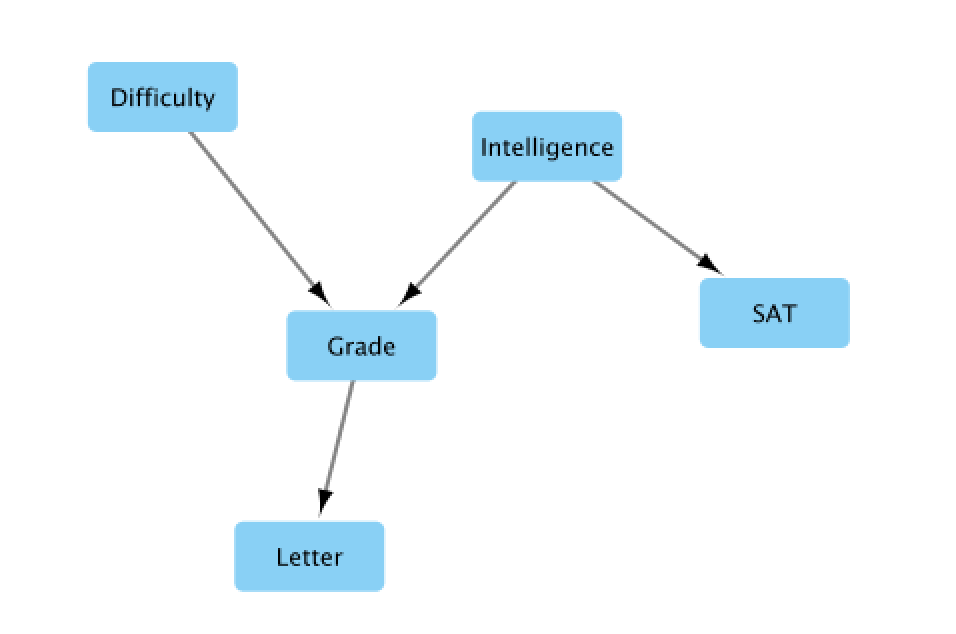

In [324]:
visualize(dr1, 'student_samples.sif', 'student_samples_sif.png', g)

## III. Parameter Learning

### A. MLE-based Parameter Learning

** a. Simple Toy Example **

In [352]:
from scipy.stats import bernoulli
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [339]:
def mle_coin(theta, num_flips, verbose=1):
    data = bernoulli.rvs(theta, size=num_flips)
    step_thetas = [data[:i].sum()/i for i in range(1,len(data)+1)] # estimate theta_hat at each flip.
    heads = data.sum()
    final_theta = heads / num_flips
    if verbose:
        print "Step Estimates: ", step_thetas
        print "Final Estimate: ", final_theta
    return step_thetas, final_theta

In [342]:
ret = mle_coin(theta=.3, num_flips=10)

Step Estimates:  [1.0, 0.5, 0.33333333333333331, 0.25, 0.20000000000000001, 0.16666666666666666, 0.14285714285714285, 0.125, 0.22222222222222221, 0.29999999999999999]
Final Estimate:  0.3


In [359]:
def mle_coin_visualize(theta, num_flips_list):
    colors = matplotlib.rcParams['axes.color_cycle'] # [u'b', u'g', u'r', u'c', u'm', u'y', u'k']
    f, ax = plt.subplots(len(num_flips_list),1,figsize=(20,10))
    f.tight_layout()
    plt.subplots_adjust(hspace=1)
    for i,num_flips in enumerate(num_flips_list):
        step_thetas, final_theta = mle_coin(theta, num_flips, verbose=0)
        ax1 = plt.subplot(len(num_flips_list),1,i+1)
        ax1.plot(range(num_flips), step_thetas, label=num_flips, alpha=.4, lw=3)
        msg = "Number of Samples", num_flips
        ax1.set_title(msg)
        ax1.set_xlabel("$num\_flips\_list$")
        ax1.set_ylim([0.,.8])
        ax1.axhline(y=final_theta, xmin=0, xmax=1, linewidth=1, color='r') # estimate line.
        ax1.axhline(y=theta, xmin=0, xmax=1, linewidth=1, color='b') # true line.
    plt.show() 

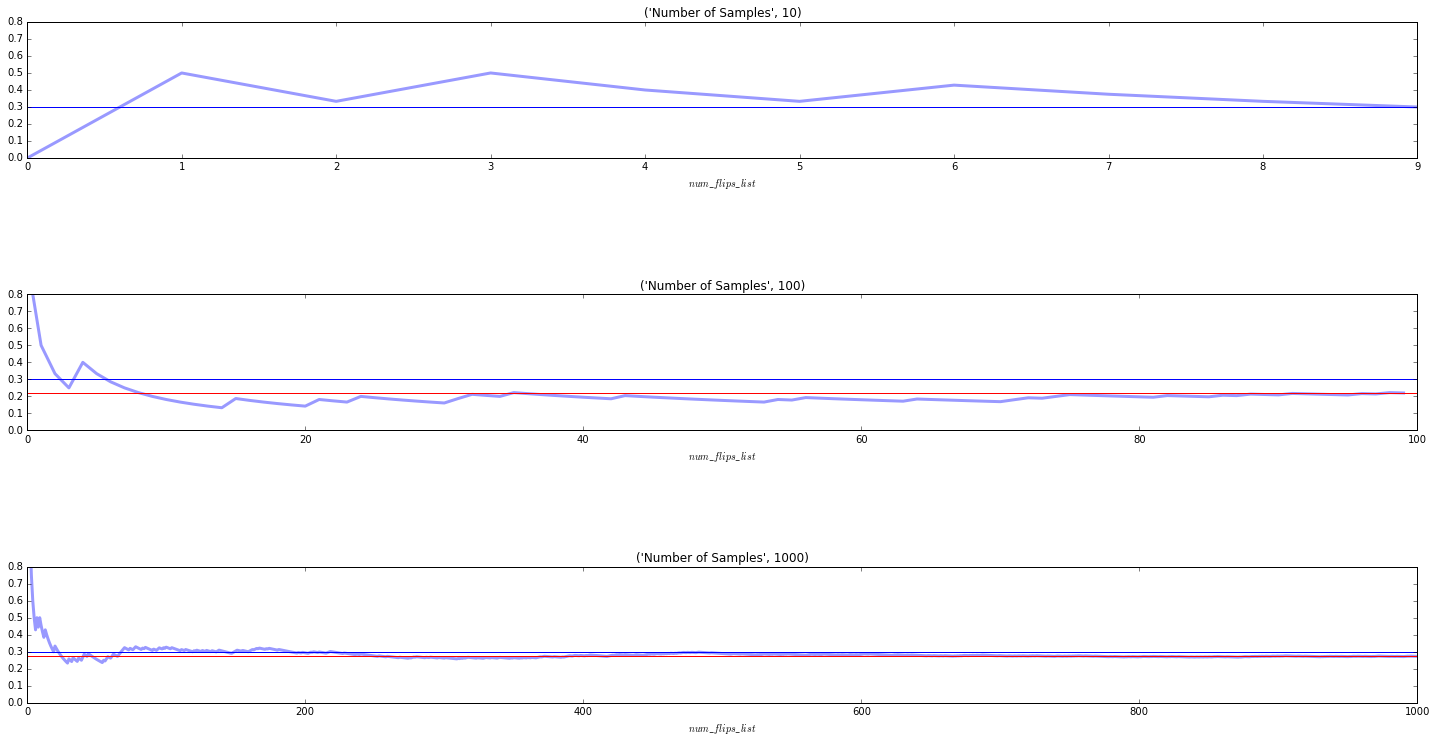

In [360]:
mle_coin_visualize(.3, [10, 100, 1000])

** b. $\texttt{Student}$ Example **

In [29]:
import pandas as pd
from libpgm.nodedata import NodeData
from libpgm.graphskeleton import GraphSkeleton
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.tablecpdfactor import TableCPDFactor
from libpgm.pgmlearner import PGMLearner

In [362]:
dr1 = "/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/9004OS_Code/9004OS_02_Code/"
encode_data(dr1, 'student.txt', student) # data constructed in section I.

In [363]:
nd = NodeData()
skel = GraphSkeleton()
nd.load(dr1+'student.txt')
skel.load(dr1+'student.txt')
skel.toporder()

In [375]:
bn = DiscreteBayesianNetwork(skel, nd)
learner = PGMLearner()

In [379]:
ret2000 = learner.discrete_mle_estimateparams(skel, bn.randomsample(2000))
ret10000 = learner.discrete_mle_estimateparams(skel, bn.randomsample(10000))
ret50000 = learner.discrete_mle_estimateparams(skel, bn.randomsample(50000))

In [380]:
print "True CPD for Grade"
print pd.DataFrame(student['Vdata']['Grade']['cprob']).transpose(); print
print "MLE Estimated CPD for Grade (2000 Samples)"
print pd.DataFrame(ret2000.Vdata['Grade']['cprob']).transpose(); print # DataFrame take dict keys as cols, 
print "MLE Estimated CPD for Grade (10000 Samples)"                 #   we need them to be rows.
print pd.DataFrame(ret10000.Vdata['Grade']['cprob']).transpose(); print
print "MLE Estimated CPD for Grade (50000 Samples)"
print pd.DataFrame(ret50000.Vdata['Grade']['cprob']).transpose() 

True CPD for Grade
               0     1     2
['0', '0']  0.30  0.40  0.30
['0', '1']  0.05  0.25  0.70
['1', '0']  0.90  0.08  0.02
['1', '1']  0.50  0.30  0.20

MLE Estimated CPD for Grade (2000 Samples)
                   0         1         2
['0', '0']  0.414832  0.310545  0.274623
['0', '1']  0.081232  0.896359  0.022409
['1', '0']  0.234862  0.056881  0.708257
['1', '1']  0.297872  0.497872  0.204255

MLE Estimated CPD for Grade (10000 Samples)
                   0         1         2
['0', '0']  0.302894  0.392315  0.304791
['0', '1']  0.895297  0.080627  0.024076
['1', '0']  0.053794  0.247239  0.698967
['1', '1']  0.498741  0.296390  0.204870

MLE Estimated CPD for Grade (50000 Samples)
                   0         1         2
['0', '0']  0.400163  0.299150  0.300687
['0', '1']  0.080355  0.020390  0.899255
['1', '0']  0.252573  0.696899  0.050529
['1', '1']  0.307808  0.195375  0.496816


### B. Bayesian Parameter Estimation

** a. Simple Toy Example **

In [381]:
from pymc import *
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import pymc.Matplot as plott
%matplotlib inline

In [387]:
def make_model(data):
    uni_prior = Uniform('uni_prior',lower=0.,upper=1.)
    bern = Bernoulli('bern',p=uni_prior,value=data,observed=True)
    model = Model([uni_prior,bern])
    return model

In [388]:
def get_traces(sample_size): # trace: traces in a random walk.
    data = bernoulli.rvs(.3,size=sample_size)
    model = make_model(data)
    model.seed()
    mc = MCMC(model)
    mc.sample(iter=5000,burn=1000) # burn: variables will not be tallied until this many iterations are complete.
                                   #       default = 0. with this we avoid over-bias towards the prior.
    return mc, mc.trace('uni_prior')[:]

 [-----------------100%-----------------] 5000 of 5000 complete in 0.2 secGenerating histogram of Sample Size = 20
 [-----------------100%-----------------] 5000 of 5000 complete in 0.2 secGenerating histogram of Sample Size = 50
 [-----------------100%-----------------] 5000 of 5000 complete in 0.2 secGenerating histogram of Sample Size = 100
 [-----------------100%-----------------] 5000 of 5000 complete in 0.2 secGenerating histogram of Sample Size = 500
 [-----------------100%-----------------] 5000 of 5000 complete in 0.5 secGenerating histogram of Sample Size = 5000


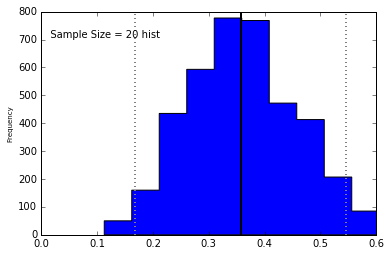

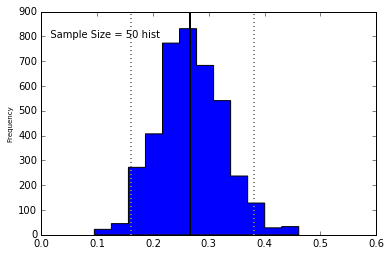

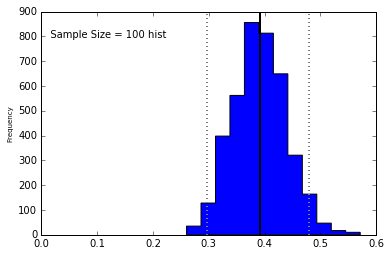

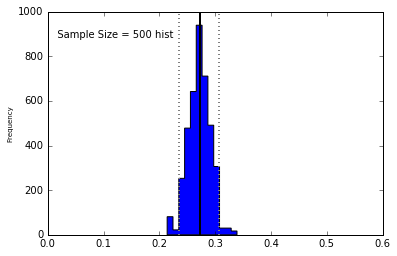

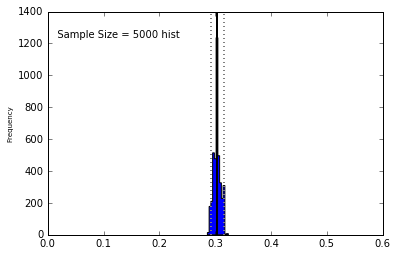

In [389]:
num_samples = [20, 50, 100, 500, 5000]
for i in num_samples:
    m, traces = get_traces(i)
    plott.histogram(traces, "Sample Size = "+str(i), datarange=(0,0.6))

In [393]:
from IPython.display import display, Image

In [401]:
def mcmc_visualize(dr, filename, sample_size=5000):
    mc, traces = get_traces(sample_size)
    gdot = pymc.graph.dag(mc) # dependencies: pydot (pip), base graphviz (pip), pygraphviz (brew install graphviz).
    gdot.write_png(dr+filename)
    display(Image(filename=dr+filename,width='10%'))

 [-----------------100%-----------------] 5000 of 5000 complete in 0.5 sec

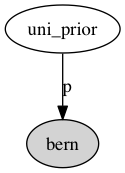

In [402]:
mcmc_visualize(dr1, 'coin_mcmc.png')

** b. $\texttt{Student}$ Example **

In [456]:
import pandas as pd
from libpgm.nodedata import NodeData
from libpgm.graphskeleton import GraphSkeleton
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.tablecpdfactorization import TableCPDFactorization
from pymc import *
from pymc.Matplot import plot
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict

In [469]:
nd = NodeData()
skel = GraphSkeleton()
nd.load(dr1+'student.txt')
skel.load(dr1+'student.txt')
skel.toporder()
bn = DiscreteBayesianNetwork(skel, nd)

In [698]:
def make_model(data,num_draws): # 2-val case (e.g. Intelligence) is done by d   
    partial_dirich = pymc.Dirichlet(name='partial_dirich',theta=[1.,1.,1.]) # k-1 probs stored.
    full_dirich = pymc.CompletedDirichlet(name='full_dirich',D=partial_dirich) # last prob stored.
    multi = pymc.Multinomial(name='multi',value=data,n=num_draws,p=full_dirich,observed=True)
    model = Model([partial_dirich,full_dirich,multi])
    return model

def run_mcmc(model, **kwargs):
    mcmc = pymc.MCMC(model)
    mcmc.sample(**kwargs)
    return mcmc

def get_counts(vals): # from 0,1,2,... result to c(0),c(1),... freq-counts.
    freqs = {1:0,2:0,3:0}
    for val in vals:
        freqs[val] = freqs.get(val,0) + 1 
    return np.asarray(freqs.values())

def get_samples(experiments, evidence, num_samples=10):
    # for n experiments, sample and add the freqs obtained.
    ret = []
    for i in xrange(experiments):
        vals = [float(i['Grade']) for i in bn.randomsample(num_samples,evidence)]
        ret.append(get_counts(vals))
    return ret

def plot_traces(traces):
    # colors = ["#348ABD","#A60628","#884732"]
    colors = ['r','b','g']
    plt.plot(np.arange(len(traces)),traces[:,:,0],c=colors[0])
    plt.plot(np.arange(len(traces)),traces[:,:,1],c=colors[1])
    plt.plot(np.arange(len(traces)),traces[:,:,2],c=colors[2])
    plt.title("Traces of Posteriors")
    plt.show()
    
def estimate_params(evidence, **kwargs):
    experiments = 10
    samples = get_samples(experiments, evidence, num_samples=10)
    model = make_model(samples, experiments)
    mc = run_mcmc(model,**kwargs)
    traces = mc.trace('full_dirich')[:]
    return [np.mean(traces[:,:,0]), np.mean(traces[:,:,1]), np.mean(traces[:,:,2])], traces

 [-----------------100%-----------------] 5000 of 5000 complete in 0.5 sec

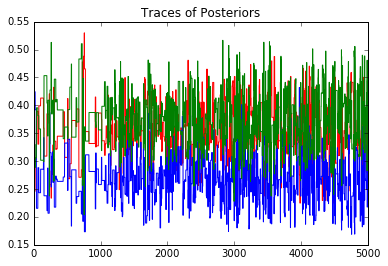

CPU times: user 718 ms, sys: 8.97 ms, total: 727 ms
Wall time: 729 ms


In [699]:
%%time
means, traces = estimate_params(dict(), iter=5000)
plot_traces(traces)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.0 sec

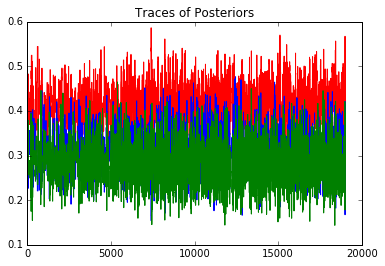

CPU times: user 2.25 s, sys: 26.6 ms, total: 2.28 s
Wall time: 2.29 s


In [700]:
%%time
means, traces = estimate_params(dict(), iter=20000, burn=1000)
plot_traces(traces)

In [701]:
print "Grade = 1: ", TableCPDFactorization(bn).specificquery(query=dict(Grade='1'),evidence=dict()) 
print "Grade = 2: ", TableCPDFactorization(bn).specificquery(query=dict(Grade='2'),evidence=dict()) 
print "Grade = 3: ", TableCPDFactorization(bn).specificquery(query=dict(Grade='3'),evidence=dict()) 

Grade = 1:  0.362
Grade = 2:  0.2884
Grade = 3:  0.3496


In [703]:
cond_assignments = [['0','0'],['0','1'],['1','0'],['1','1']]
ret = []
for i,j in cond_assignments:
    evidence = dict(Intelligence=i, Difficulty=j)
    means, traces = estimate_params(evidence, iter=50000, burn=10000)
    ret.append([[i,j]] + means)
pd.DataFrame(ret, columns=['cond_assignment',0,1,2])

 [-----------------100%-----------------] 50000 of 50000 complete in 4.8 sec

,cond_assignment,0,1,2
0,"[0, 0]",0.272026,0.456067,0.271907
1,"[0, 1]",0.048356,0.280531,0.671113
2,"[1, 0]",0.873006,0.088116,0.038877
3,"[1, 1]",0.554015,0.252596,0.193389


In [614]:
print "True CPD for Grade"
print pd.DataFrame(student['Vdata']['Grade']['cprob']).transpose(); print

True CPD for Grade
               0     1     2
['0', '0']  0.30  0.40  0.30
['0', '1']  0.05  0.25  0.70
['1', '0']  0.90  0.08  0.02
['1', '1']  0.50  0.30  0.20



## IV. Inference

### A. Exact Inference I. Variable Elimination

Diagnostic Network


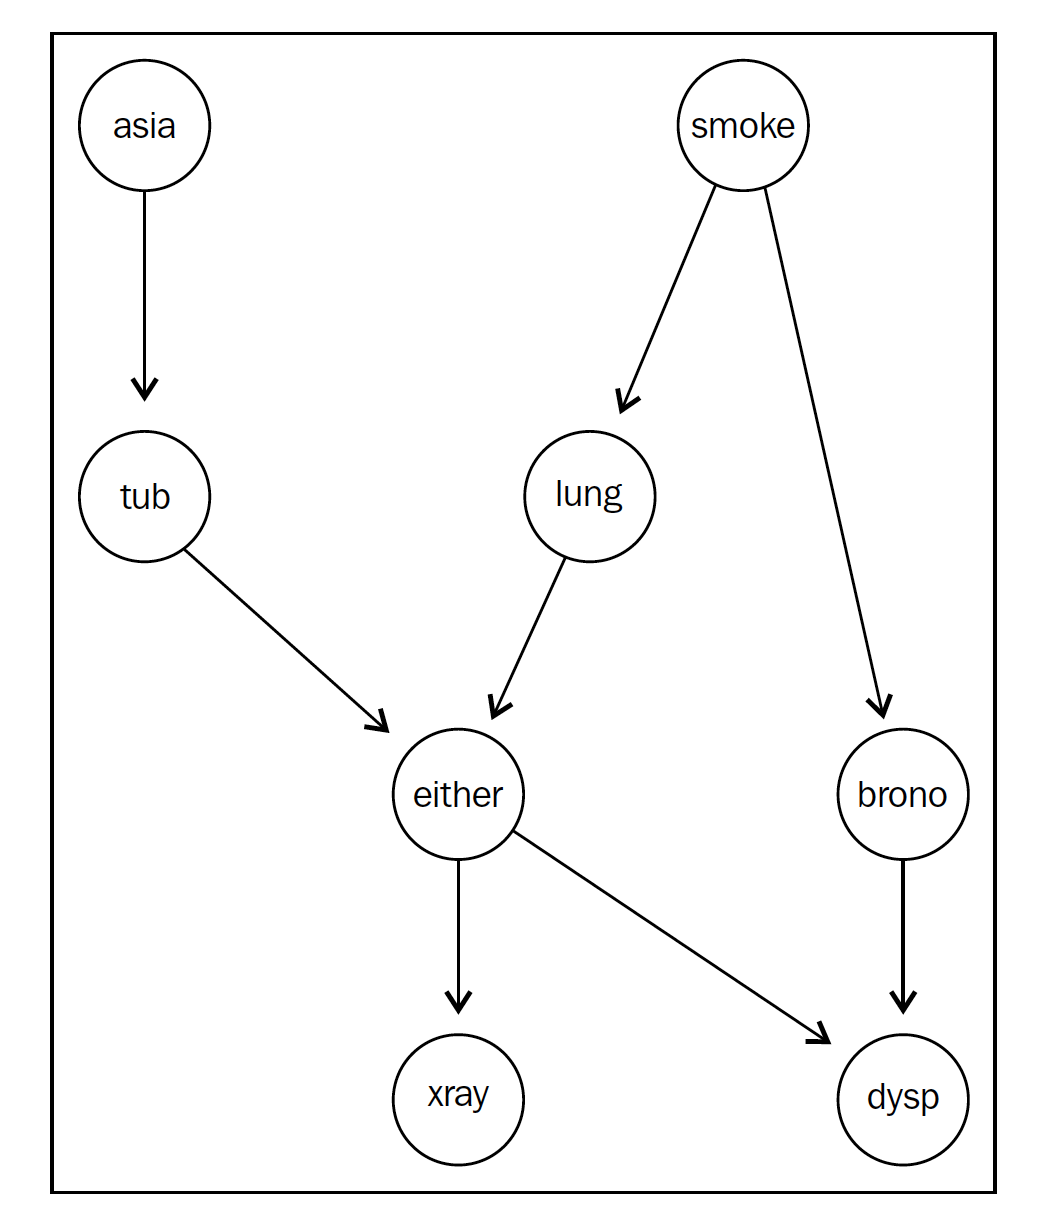

In [112]:
print "Diagnostic Network"
display(Image(filename='/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/FIGS/asia_bn.png',
              width='30%'))

In [113]:
import pandas as pd
import itertools
from libpgm.nodedata import NodeData
from libpgm.graphskeleton import GraphSkeleton
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.tablecpdfactor import TableCPDFactor # this is for single CPD.
from libpgm.tablecpdfactorization import TableCPDFactorization # this is for the entire network.

In [114]:
dr2 = "/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/9004OS_Code/9004OS_06_Code/"
# del sum # in case pymc.xxx.sum overwrote this in the last section.

** a. Method 1: Brute Force **

* Complexity: $O(2^n)$
* E.g. $P(bronc=Yes\mid smoke=Yes)$

In [115]:
nd = NodeData()
skel = GraphSkeleton()
nd.load(dr2+'asia1.txt')
skel.load(dr2+'asia1.txt')
skel.toporder()
bn = DiscreteBayesianNetwork(skel, nd)

In [116]:
# FACTOR MULTIPLICATION
tcpd_f = TableCPDFactor('asia',bn) # initialize at asia node.
for i in bn.V:
    if i!='asia':
        tcpd_f.multiplyfactor(TableCPDFactor(i,bn))

In [117]:
def tabulate_jointdist(tcpd_f, bn, normalize=False): # get full assignment/factor table
    var_vals = [bn.Vdata[i]['vals'] for i in tcpd_f.scope]
    probs = [i/sum(tcpd_f.vals) for i in tcpd_f.vals] if normalize else tcpd_f.vals # 256 probs (256 assignments).
    table = [assignment+[prob] for assignment,prob in zip([list(i) for i in itertools.product(*var_vals[::-1])],
                                                          probs)]
    df = pd.DataFrame.from_records(table, columns=[i for i in reversed(tcpd_f.scope)]+['prob']) # read data as ndarray.
    return df

In [118]:
df = tabulate_jointdist(tcpd_f, bn, normalize=1)

In [119]:
df.head()

,dysp,xray,either,tub,lung,bronc,smoke,asia,prob
0,yes,yes,yes,yes,yes,yes,yes,yes,1.323000e-05
1,yes,yes,yes,yes,yes,yes,yes,no,2.619540e-04
2,yes,yes,yes,yes,yes,yes,no,yes,6.615000e-07
3,yes,yes,yes,yes,yes,yes,no,no,1.309770e-05
4,yes,yes,yes,yes,yes,no,yes,yes,6.860000e-06


In [120]:
# FACTOR REDUCTION
df_bronc_smoke_gb = df.groupby(['bronc','smoke'], as_index=False)
df_bronc_smoke = df_bronc_smoke_gb['prob'].sum()

In [121]:
df_bronc_smoke

,bronc,smoke,prob
0,no,no,0.35
1,no,yes,0.20
2,yes,no,0.15
3,yes,yes,0.30


** b. VE Algorithm **

* Complexity: $O(|V|^k)$, where $|V|$ is the max number of values a variable can take, $k$ is the number of variables. 
* Demo: 
$$\begin{align}
		P(E) &= \sum_{A,B,C,D}\tilde{P}(A,B,C,D,E)\\
		&= \sum_{A,B,C,D}\phi_1(A,B)\phi_2(B,C)\phi_3(C,D)\phi_4(D,E)\\
		&= \sum_{B,C,D}\phi_2(B,C)\phi_3(C,D)\phi_4(D,E)\sum_A\phi_1(A,B)\\
		&= \sum_{B,C,D}\phi_2(B,C)\phi_3(C,D)\phi_4(D,E)\tau_1(B)\\
		&= \sum_{C,D}\phi_3(C,D)\phi_4(D,E)\sum_B\phi_2(B,C)\tau_1(B)\\
		&= \sum_{C,D}\phi_3(C,D)\phi_4(D,E)\tau_2(C)\\
		&= \sum_D\phi_4(D,E)\sum_C\phi_3(C,D)\tau_2(C)\\
		&= \sum_D\phi_4(D,E)\tau_3(D)\\
		&= \tau_4(E)
    \end{align}$$
* E.g. $P(bronc=Yes\mid smoke=Yes)$

In [122]:
# SINGLE STEP SUMMING-OUT (e.g. factor w/ 'asia', 'tub')
asia = TableCPDFactor('asia', bn) # can't do one-liner, must create a TableCPDFactor object.
phi_1 = TableCPDFactor('tub', bn)
phi_1.multiplyfactor(asia) # this produces phi('asia','tub')
tabulate_jointdist(phi_1, bn)

,asia,tub,prob
0,yes,yes,0.0005
1,yes,no,0.0095
2,no,yes,0.0099
3,no,no,0.9801


In [123]:
phi_1.sumout('asia') # \sum_'asia'[phi('asia','tub')]
tabulate_jointdist(phi_1, bn)

,tub,prob
0,yes,0.0104
1,no,0.9896


In [127]:
query, evidence = {'bronc':'yes'}, {'smoke':'yes'}
tcpd = TableCPDFactorization(bn)
ret = tcpd.condprobve(query, evidence)
tabulate_jointdist(ret, bn)

,bronc,prob
0,yes,0.6
1,no,0.4


### B. Exact Inference II. Message Passing

* Recource: https://github.com/eBay/bayesian-belief-networks

** a. Clique Tree Construction Demo **

0\. Read in some graph

In [837]:
# import bif_parser # original code, which doesn't work with my system. 
import asia_bn # sys.path.append('/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/UTILS/')
               # the module contains the code that creates asia graph, customizable.
import prettytable
import pydot
from IPython.core.display import Image
from bayesian.bbn import *

In [838]:
bg = asia_bn.create_bbn()

In [860]:
def bbn_visualize(graphviz_data):
    graph = pydot.graph_from_dot_data(graphviz_data)[0] # function returns [<pydot.Dot at xxx>], select [0].
    graph.write_png(dr2+'temp.png')
    return dr2+'temp.png'

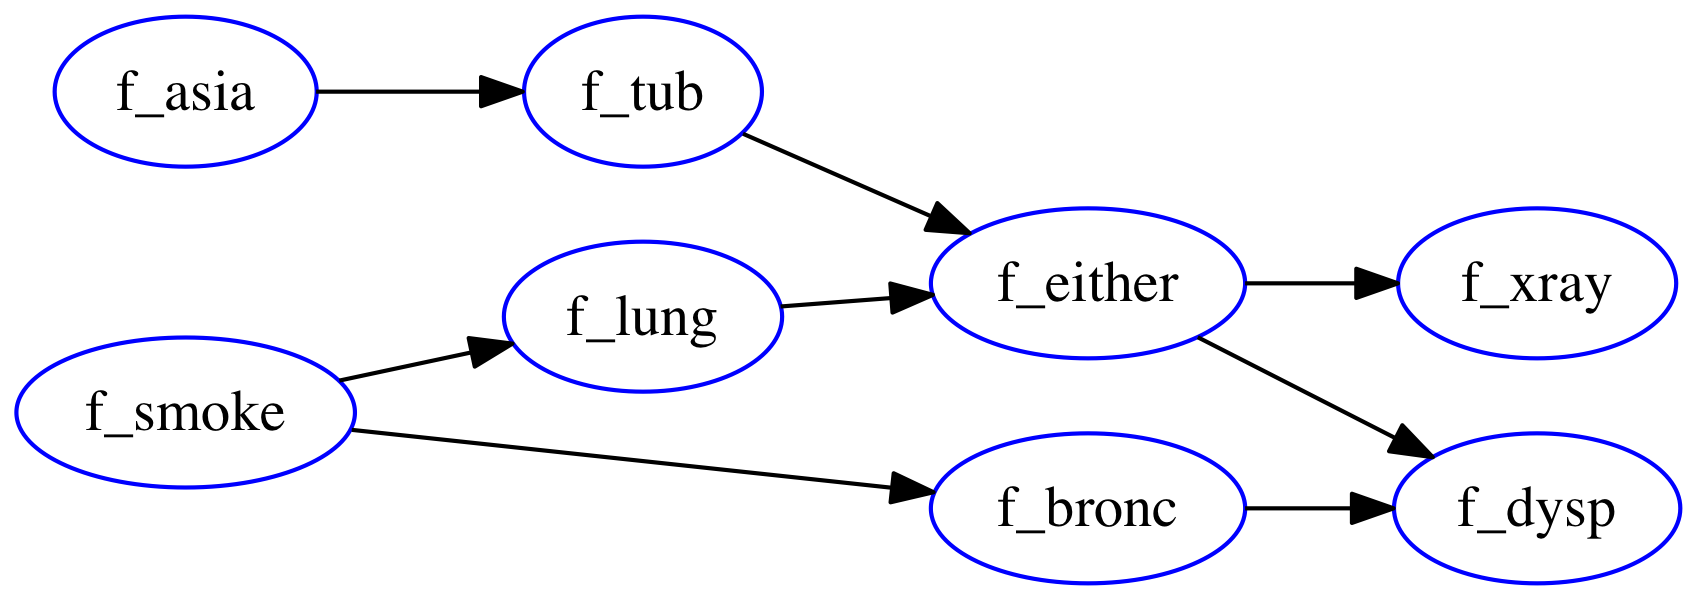

In [861]:
gd1 = bg.get_graphviz_source() # gd stands for graph dot.
display(Image(filename=bbn_visualize(gd1),width="40%"))

1\. Moralization 

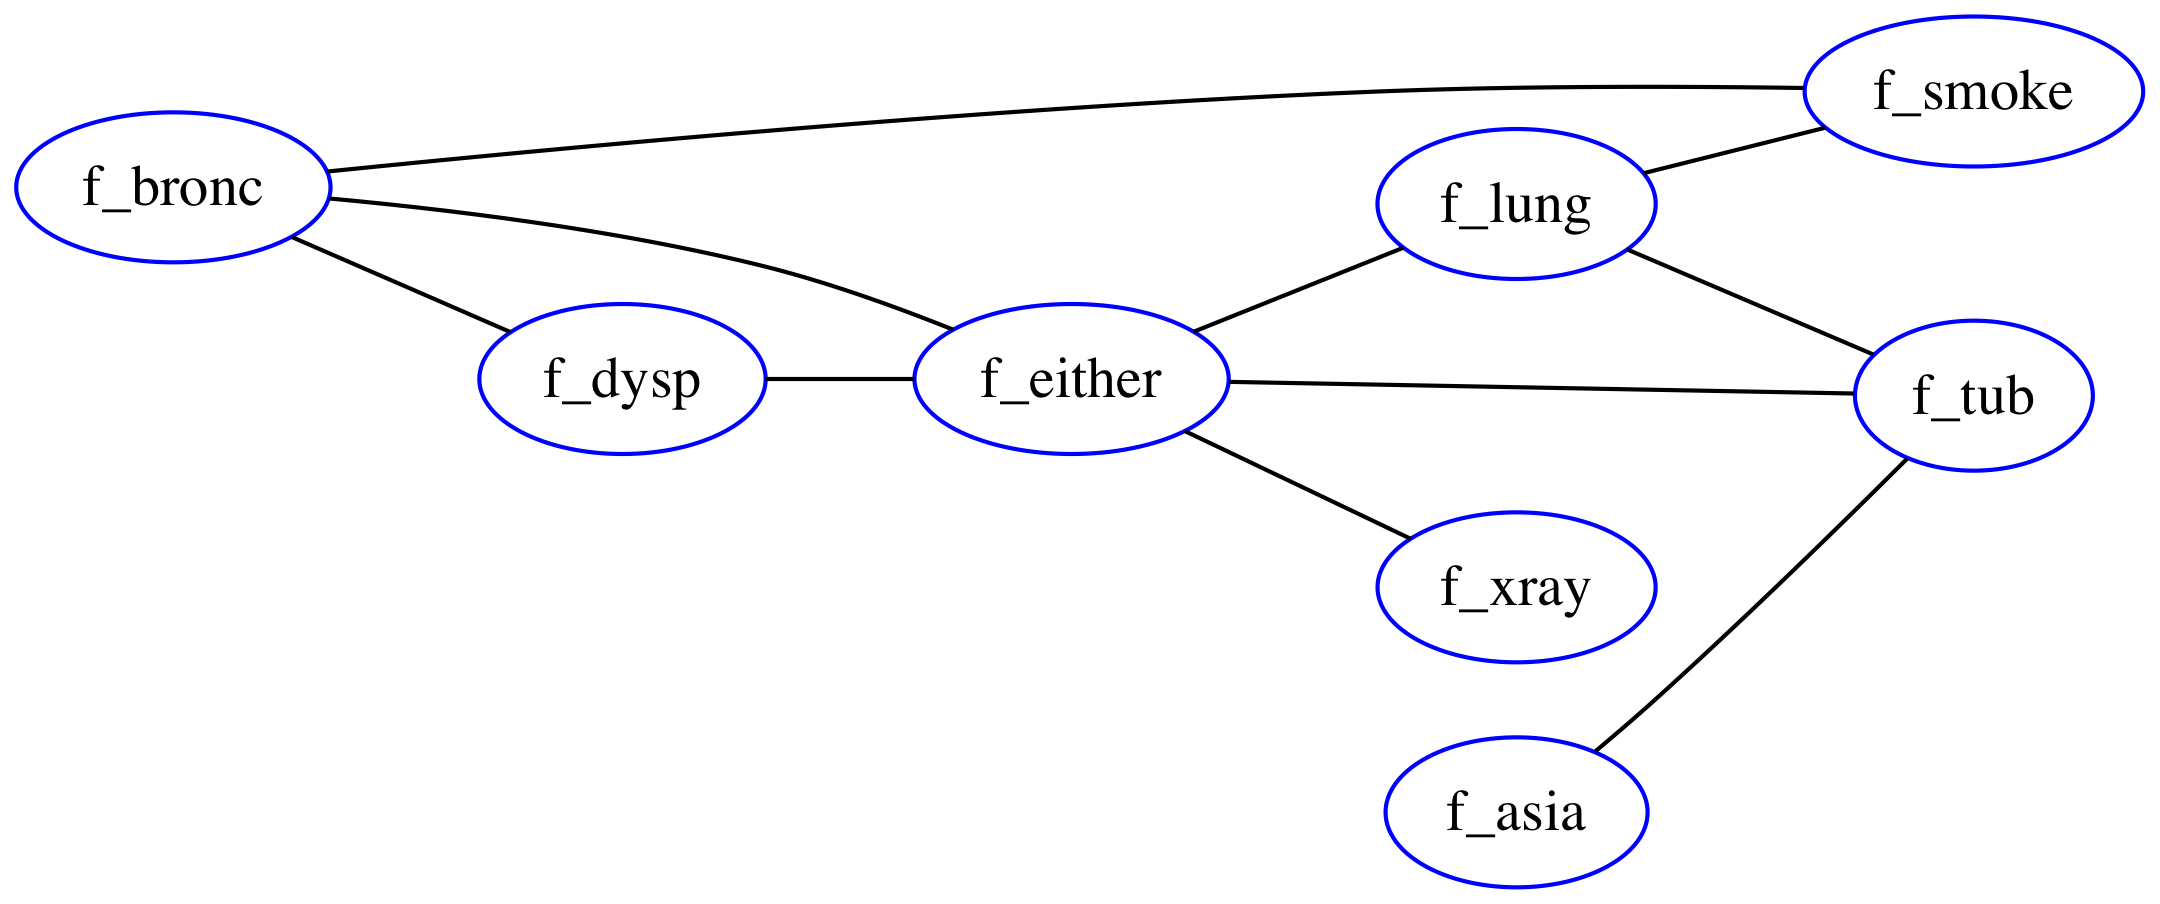

In [863]:
gd2 = make_moralized_copy(make_undirected_copy(bg),bg).get_graphviz_source()
display(Image(filename=bbn_visualize(gd2),width="40%"))

2\. Triangulation

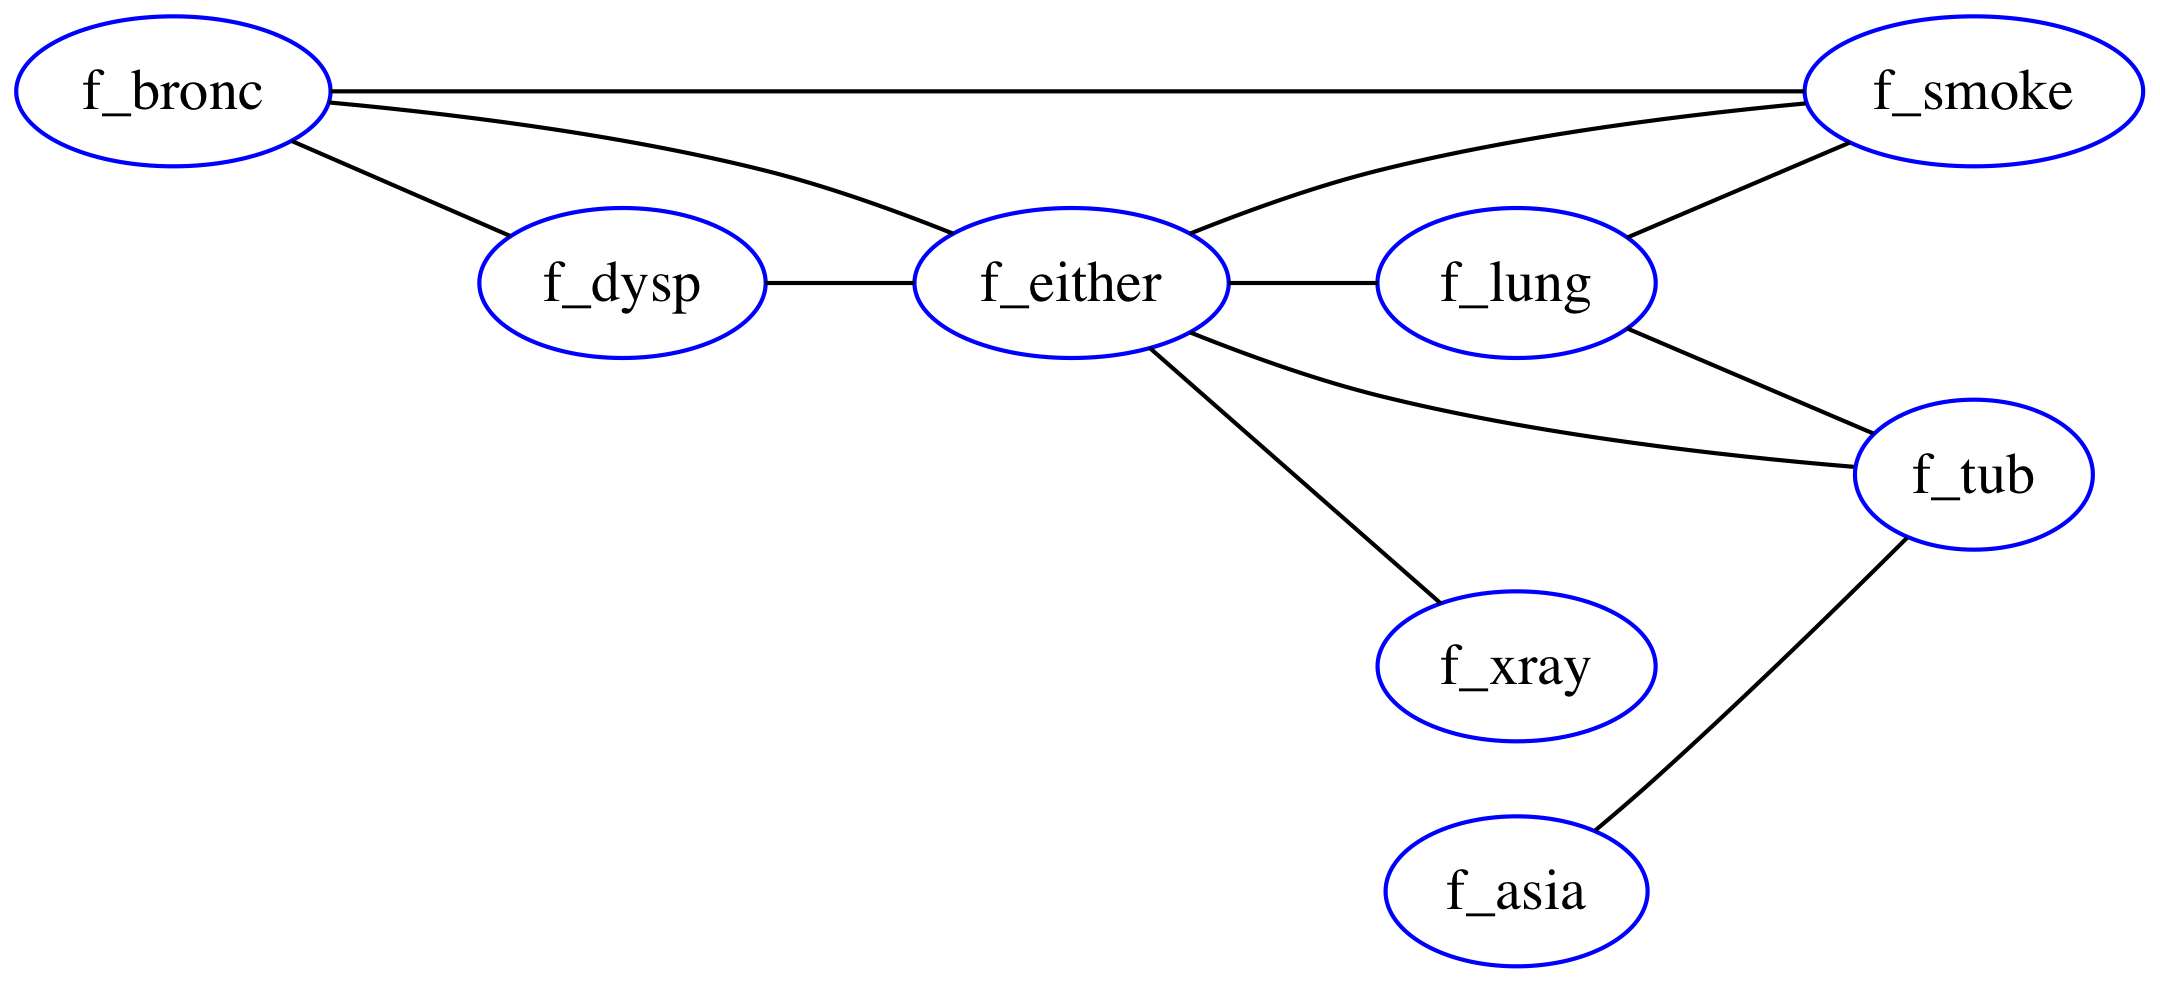

In [864]:
tmp = make_moralized_copy(make_undirected_copy(bg),bg)
cliques, elimination_ordering = triangulate(tmp, priority_func)
gd3 = tmp.get_graphviz_source()
display(Image(filename=bbn_visualize(gd3),width="40%"))

3\. Build Clique Tree

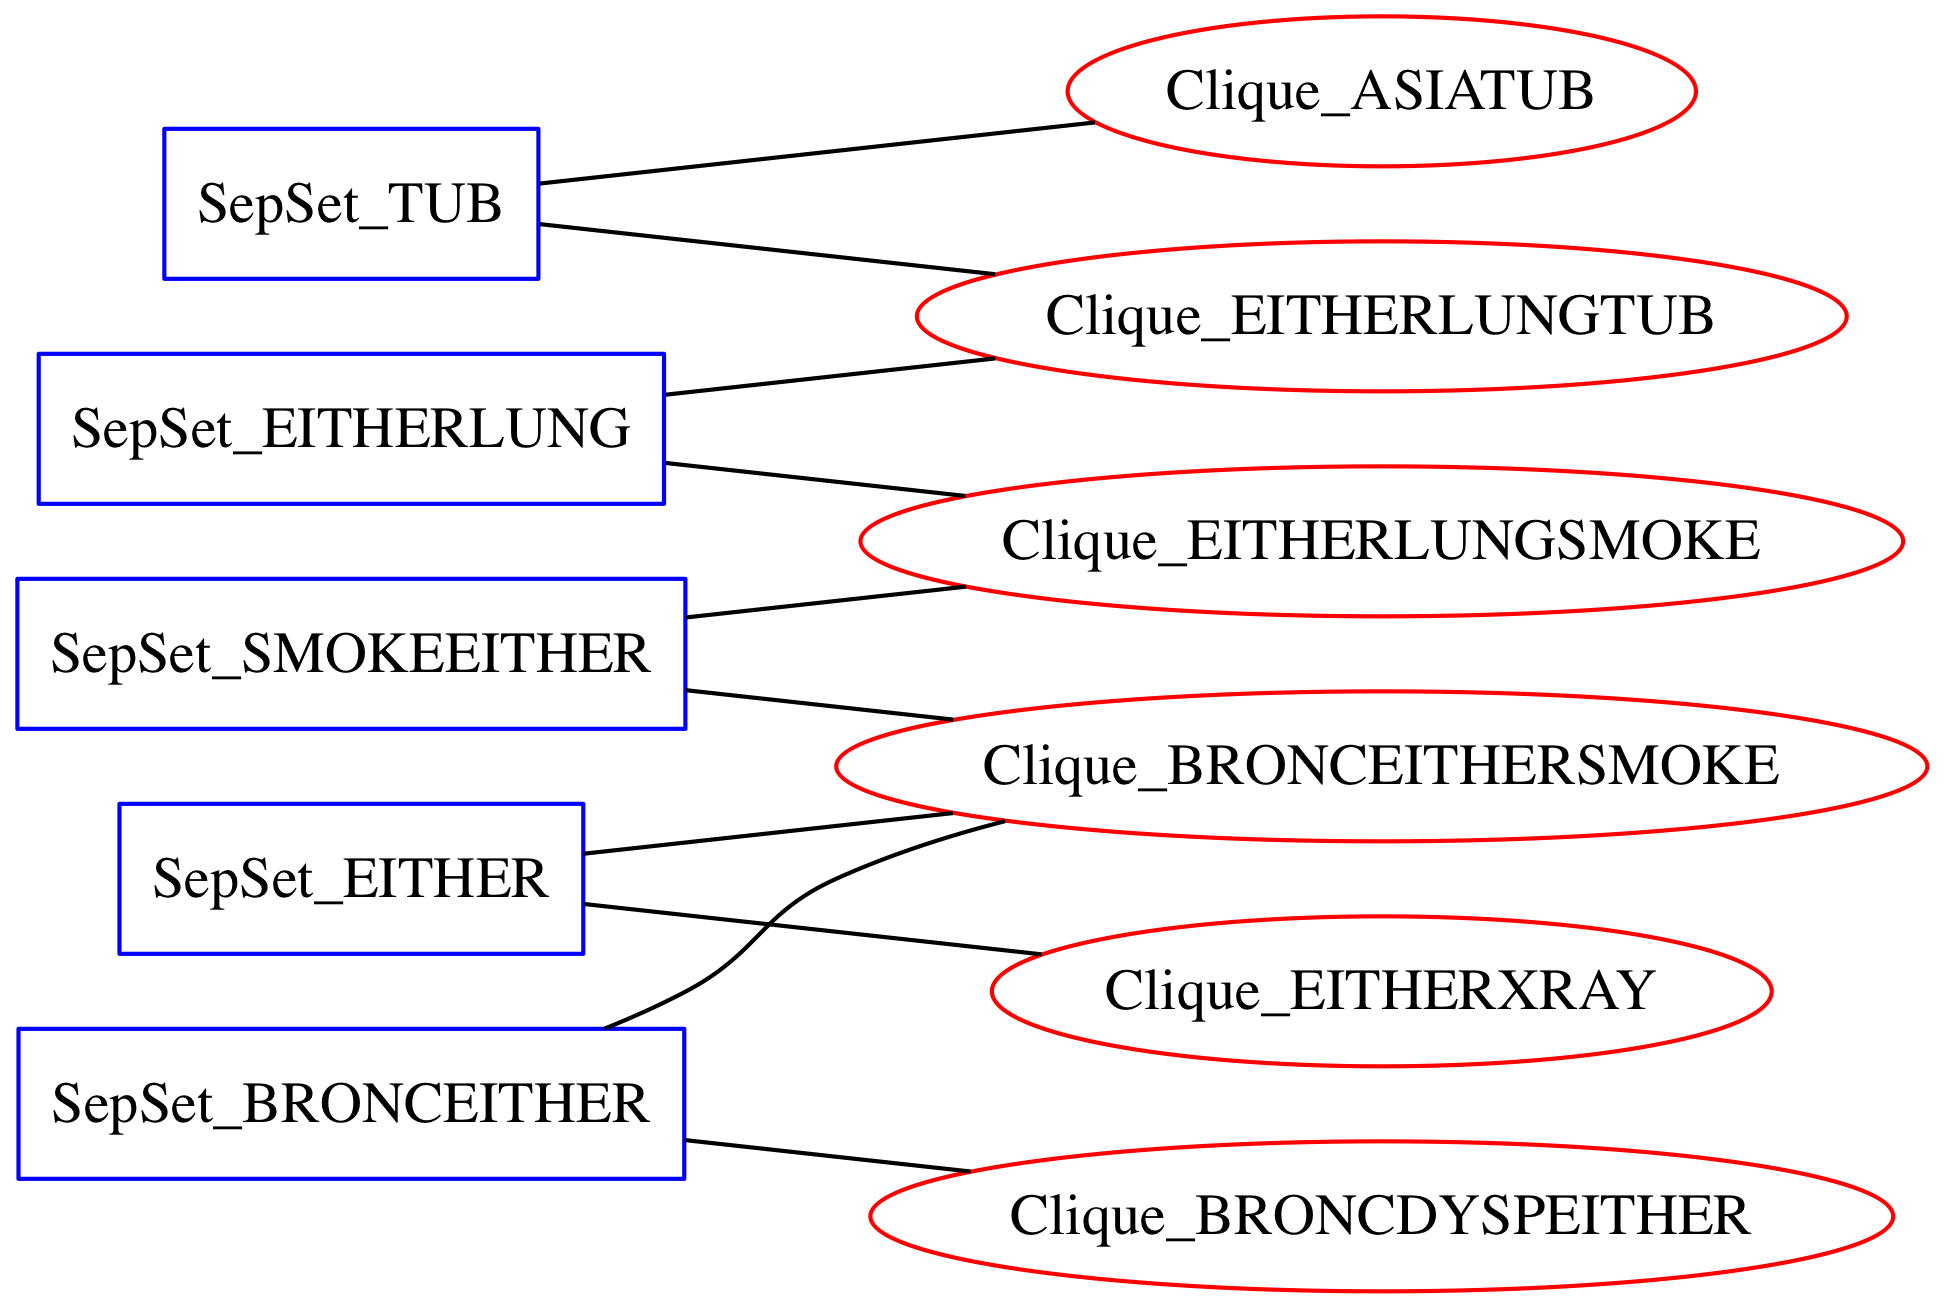

In [865]:
clique_tree = bg.build_join_tree()
gd4 = clique_tree.get_graphviz_source()
display(Image(filename=bbn_visualize(gd4),width="40%"))

** b. Message Passing **

1\. Initialize Potentials

In [867]:
assignments = clique_tree.assign_clusters(bg)
clique_tree.initialize_potentials(assignments, bg)

2\. Pass Message Until Convergence (Clique Calibration)

In [869]:
clique_tree.propagate()

3\. Inference: Find the Cluster where Target Variable Present

In [870]:
[i for i in clique_tree.clique_nodes for v in i.variable_names if v=='bronc']

[<JoinTreeCliqueNode: Clique_BRONCDYSPEITHER>,
 <JoinTreeCliqueNode: Clique_BRONCEITHERSMOKE>]

In [871]:
[i for i in clique_tree.clique_nodes for v in i.variable_names if v=='bronc'][0].potential_tt

{(('bronc', 'no'), ('dysp', 'no'), ('either', 'no')): 0.46892195999999997,
 (('bronc', 'no'), ('dysp', 'no'), ('either', 'yes')): 0.008692680000000001,
 (('bronc', 'no'), ('dysp', 'yes'), ('either', 'no')): 0.05210244,
 (('bronc', 'no'), ('dysp', 'yes'), ('either', 'yes')): 0.020282920000000003,
 (('bronc', 'yes'), ('dysp', 'no'), ('either', 'no')): 0.08282951999999999,
 (('bronc', 'yes'), ('dysp', 'no'), ('either', 'yes')): 0.003585240000000001,
 (('bronc', 'yes'), ('dysp', 'yes'), ('either', 'no')): 0.33131807999999996,
 (('bronc', 'yes'), ('dysp', 'yes'), ('either', 'yes')): 0.03226716000000001}

In [876]:
from __future__ import division
sum_out = lambda imap,pair: sum([v for entry,v in imap.iteritems() for e in entry if e==pair]) # entry: [ass,prob].
                                                                                               # pair: [var,val].
def binary_bbn_query(target_var): 
    imap = [i for i in clique_tree.clique_nodes 
              for v in i.variable_names if v==target_var][0].potential_tt # just take the first.
                                                                          # cuz tree's calibrated anyway.
    yes, no = [sum_out(imap,(target_var,val)) for val in ['yes','no']]
    print target_var
    print 'yes: %.2f%% | no %.2f%%' % (yes/(yes+no)*100,no/(yes+no)*100)

In [877]:
binary_bbn_query('bronc')

bronc
yes: 45.00% | no 55.00%


### C. Approx. Inference I. Optimization-Based

In [3]:
import opengm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline
from PIL import Image

In [4]:
dr3 = "/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/9004OS_Code/9004OS_07_Code/"

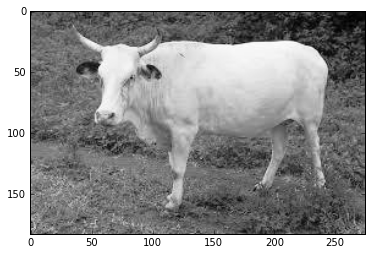

In [5]:
image = Image.open(dr3+'cow_image.jpg').convert("L")
arr = np.asarray(image).astype(float)/255
plt.imshow(arr, cmap=cm.Greys_r)
plt.show()

In [6]:
from IPython.display import Image as pyimg # in naming conflict with PIL Image.
from IPython.display import display

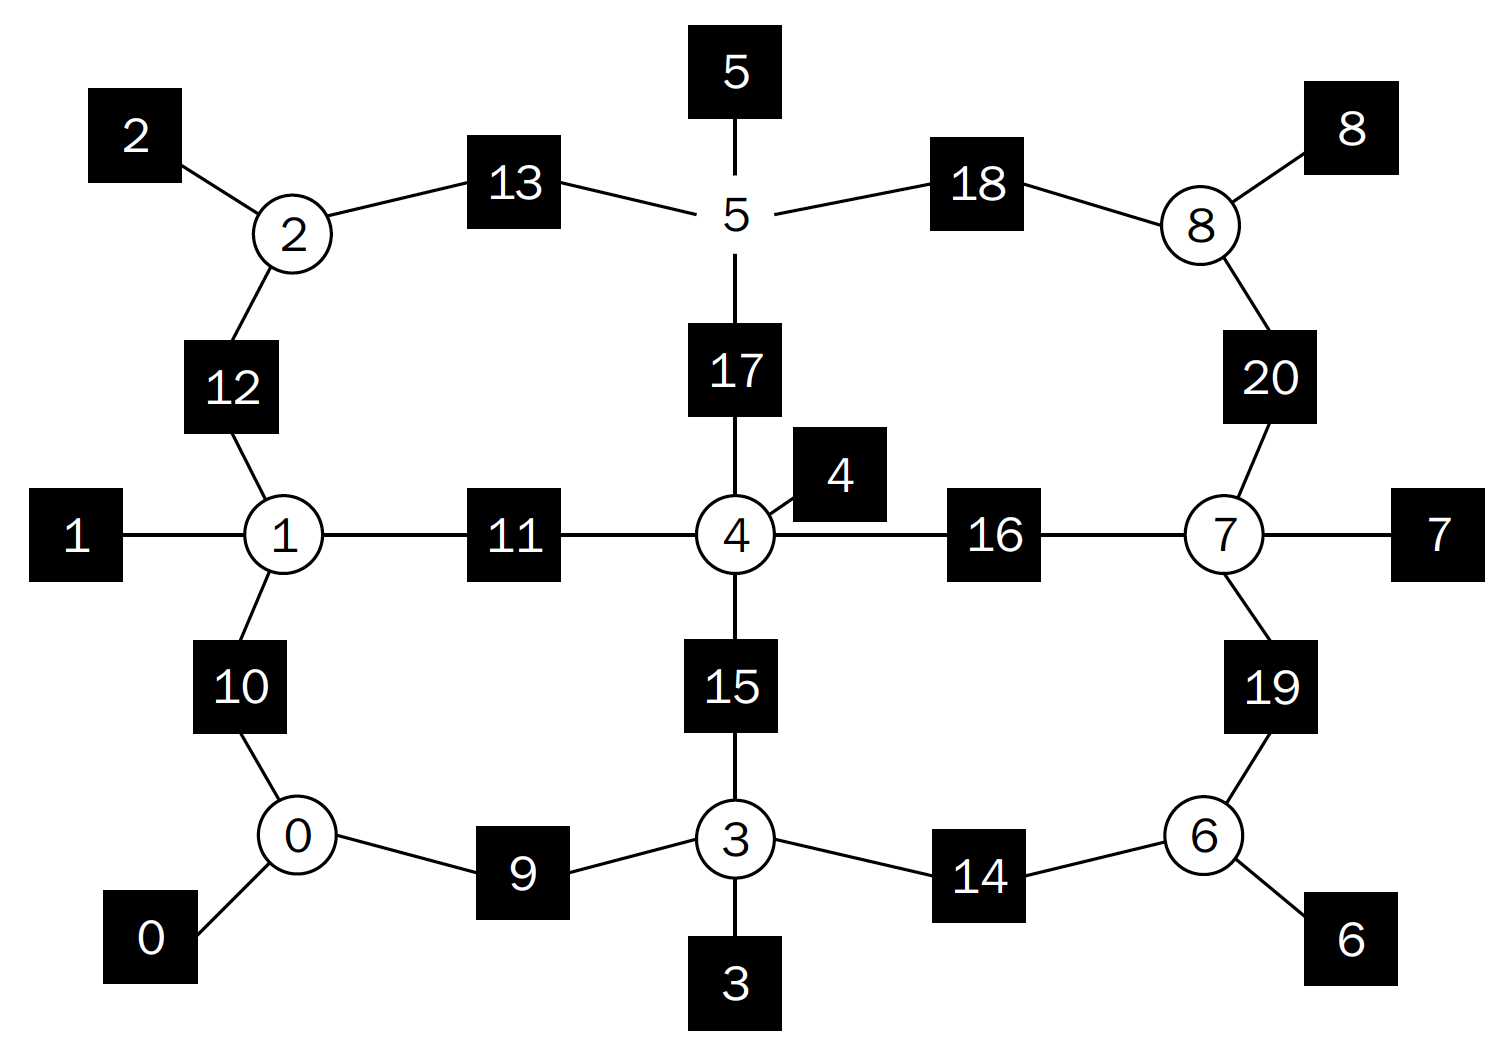

In [7]:
# ENERGY FUNC W/ UNI/BI-FACTORS
num_labels, shape = 2, (3,3)
unaries = np.random.rand(shape[0], shape[1], num_labels) # 3 x 3 x 2 tensor.
potts = opengm.PottsFunction([num_labels, num_labels], 0., .5)
gm = opengm.grid2d2Order(unaries=unaries, regularizer=potts)
# opengm.visualizeGm(gm, plotFunctions=False, plotNonShared=True, relNodeSize=.9) 
    # this now incompatible with networkx.
display(pyimg(filename='/Users/jacobsw/Desktop/UNIV/LOGIC_MATH_COMPUTATION/PGM_ADVANCED/IMPLEMENTATION/FIGS/opengm_unibi.png',
              width='50%'))

In [8]:
print "number of factors:",gm.numberOfFactors
print "number of factors of node 0: ",gm.numberOfFactorsOfVariable(0)
print "number of factors of node 4: ",gm.numberOfFactorsOfVariable(4)

number of factors: 21
number of factors of node 0:  3
number of factors of node 4:  5


##### Loopy Belief Propagation (LBP) Algorithm

* Create a PGM that has the image height $x$, width $y$, and a number of labels in its label space;
* Create unary factors, one for each pixel;
* Assign a $\mathtt{potts}$ function (i.e. as in generalized Ising model) to each factor;
* Create pairwise factors, one factor for each pair of pixels that are adjacent on the $x$ axis, and similarly for the $y$ axis;
* Assign a $\mathtt{potts}$ function to each pairwise factor;
* Pass messages until convergence (energy function stops oscillating).

In [9]:
shape = arr.shape
dimx, dimy = shape[0], shape[1]
num_var = dimx * dimy
num_lb = 2
beta = .1
num_states = np.ones(num_var, dtype=opengm.index_type)*num_lb
gm = opengm.graphicalModel(num_states)

In [12]:
# ADD UNARY FACTORS
for y in range(dimy):
    for x in range(dimx):
        f = np.ones(2, dtype=np.float32)
        f[0] = arr[x,y]
        f[1] = 1. - arr[x,y]
        fid = gm.addFunction(f)
        gm.addFactor(fid,(x*dimy+y,)) # index

In [14]:
# ADD BINARY FACTORS
f = np.ones(pow(num_lb,2), dtype=np.float32).reshape(num_lb, num_lb)*beta
for l in range(num_lb):
    f[l,l] = 0
fid = gm.addFunction(f)
for y in range(dimy):
    for x in range(dimx):
        if x+1<dimx:
            gm.addFactor(fid, np.array([x*dimy+y,(x+1)*dimy+y], dtype=opengm.index_type))
        if y+1<dimy:
            gm.addFactor(fid, np.array([x*dimy+y,x*dimy+(y+1)], dtype=opengm.index_type))

# ASSIGNMENT (at each none-left-bounary node):

#  NODE -- Factor --- NODE
#   |
#  Factor
#   |
#  NODE

In [15]:
imgplot = [] # each item in this record the value for the pixel matrix at a learning step.

class PyCallback(object):
    
    def __init__(self, shape, num_lb):
        self.shape = shape
        self.num_lb = num_lb
        matplotlib.interactive(True)
    
    def append_label_vector(self, label_vector):
        label_vector = label_vector.reshape(self.shape) # flat vector to 2D repr. of image pixel matrix.
        imgplot.append([label_vector])
        
    def check_energy(self, inference):
        gm = inference.gm()
        label_vector = inference.arg()
        print "energy", gm.evaluate(label_vector)
        self.append_label_vector(label_vector)
    
    def begin(self, inference):
        print "beginning of inference"
        self.check_energy(inference)
    
    def end(self, inference):
        print "end of inference"
    
    def visit(self, inference):
        self.check_energy(inference)
    

In [16]:
inf = opengm.inference.BeliefPropagation(gm, parameter=opengm.InfParam(damping=.05))
callback = PyCallback(shape, num_lb)
visitor = inf.pythonVisitor(callback, visitNth=1)

In [17]:
inf.infer(visitor)

beginning of inference
energy 21002.8279518
energy 16099.1964186
energy 16082.3121062
energy 16068.616029
energy 16051.3454422
energy 16031.5101499
energy 16009.4611322
energy 15989.7885849
energy 15973.5062335
energy 15958.6258427
energy 15947.0964321
energy 15933.5081981
energy 15924.8709442
energy 15915.7964352
energy 15910.2160436
energy 15903.457221
energy 15897.0356531
energy 15891.5748694
energy 15887.8317327
energy 15884.5552625
energy 15881.3552629
energy 15876.3650675
energy 15871.9807543
energy 15869.5415392
energy 15866.7336964
energy 15864.4199713
energy 15862.878795
energy 15860.1925208
energy 15858.1258544
energy 15856.5729135
energy 15854.470953
energy 15853.4278159
energy 15851.5140906
energy 15850.2062477
energy 15849.4729144
energy 15848.6493853
energy 15847.5062481
energy 15846.3258561
energy 15846.037621
energy 15844.8689936
energy 15843.5925233
energy 15843.1101704
energy 15842.3454647
energy 15842.1925236
energy 15841.3023277
energy 15839.1180142
energy 15838.692

opengm.inference._inference.InferenceTermination.NORMAL

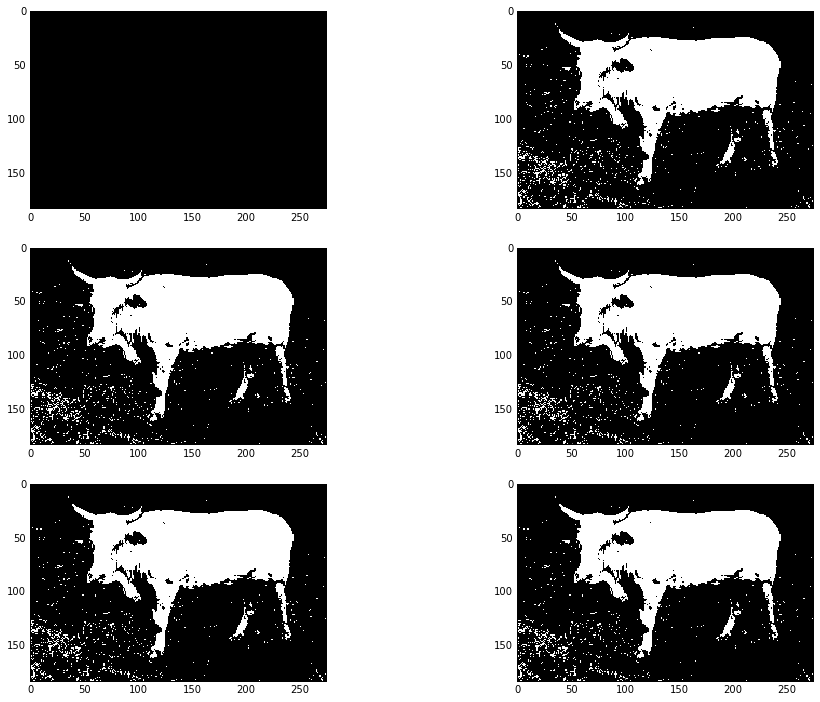

In [18]:
fig = plt.figure(figsize=(16,12))
for (counter, im) in enumerate(imgplot[0:6]):
    a = fig.add_subplot(3,2,counter+1)
    plt.imshow(im[0], cmap=cm.gray, interpolation='nearest')
plt.draw()

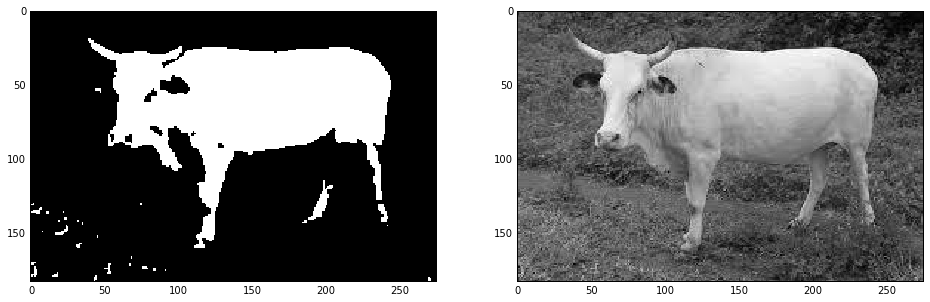

In [19]:
# MAP ASSIGNMENT PIXEL MATRIX
fig = plt.figure(figsize=(16,12))
a = fig.add_subplot(1,2,1)
plt.imshow(imgplot[-1][0], cmap=cm.gray, interpolation='nearest')
a = fig.add_subplot(1,2,2)
plt.imshow(arr, cmap=cm.gray, interpolation='nearest')
plt.draw()

### D. Approx. Inference II: Sampling

In [165]:
def get_table_cpd(dr,filename):
    nd = NodeData()
    skel = GraphSkeleton()
    json_path = dr+filename
    nd.load(json_path)
    skel.load(json_path)
    skel.toporder() 
    bn = DiscreteBayesianNetwork(skel,nd)
    table_cpd = TableCPDFactorization(bn)
    return table_cpd, bn, skel

In [174]:
tcpd, bn, skel = get_table_cpd(dr1, 'student.txt') # cf. section I.
query = {'Intelligence':'0','Grade':'0','Letter':0}
evidence = {'Difficulty':'0','SAT':'0'}
fac = tcpd.condprobve(query, evidence)
df = tabulate_jointdist(fac, bn)
df

,Letter,Grade,Intelligence,prob
0,0,1,0,0.027517
1,0,1,1,0.007448
2,0,2,0,0.146759
3,0,2,1,0.002648
4,0,3,0,0.272421
5,0,3,1,0.001639
6,1,1,0,0.247655
7,1,1,1,0.067034
8,1,2,0,0.220138
9,1,2,1,0.003972


In [183]:
def estimate_dist(skel, samples):
    learner = PGMLearner()
    bn = learner.discrete_mle_estimateparams(skel,samples)
    table_cpd = TableCPDFactorization(bn)
    fac = table_cpd.condprobve(query, evidence)
    df = tabulate_jointdist(fac, bn)
    return df

def gibbs_marginals(sample_size=5000):
    tcpd, bn, skel = get_table_cpd(dr1, 'student.txt')
    samples = tcpd.gibbssample(evidence, sample_size)
    df = estimate_dist(skel, samples)
    return df['prob']

def random_sample_marginals(sample_size=5000):
    tcpd, bn, skel = get_table_cpd(dr1, 'student.txt')
    samples = bn.randomsample(sample_size, evidence)
    df = estimate_dist(skel, samples)
    return df['prob']

In [184]:
df['prob from gibss'] = gibbs_marginals() # NOT GUARANTEED TO WORK!
df['prob from random samples'] = random_sample_marginals()
df

,Letter,Grade,Intelligence,prob,prob from gibss,prob from random samples
0,0,1,0,0.027517,0.254550,0.210833
1,0,1,1,0.007448,0.073850,0.003967
2,0,2,0,0.146759,0.214278,0.103568
3,0,2,1,0.002648,0.002922,0.008832
4,0,3,0,0.272421,0.002384,0.020246
5,0,3,1,0.001639,0.000016,0.025954
6,1,1,0,0.247655,0.030850,0.001767
7,1,1,1,0.067034,0.008950,0.000033
8,1,2,0,0.220138,0.137722,0.170832
9,1,2,1,0.003972,0.001878,0.014568
